# <b><span style='color:#F1A424'>|</span> HMS: <span style='color:#F1A424'>Harmful Brain Activity Classification</span><span style='color:#ABABAB'> [Train]</span></b> 

***

**Consider upvoting this notebook if you find it useful 🙌🏼**

- [Inference Notebook](https://www.kaggle.com/alejopaullier/hms-efficientnetb0-pytorch-inference)
- In case you don't want to train the model you can find my dataset with [5-fold trained Efficientnet models](https://www.kaggle.com/datasets/alejopaullier/hms-efficientnetb0-5-folds) that are the result of running this notebook.

This is the **PyTorch 🔥 version** of [Chris Deotte EfficientNetB0 Starter](https://www.kaggle.com/code/cdeotte/efficientnetb0-starter-lb-0-43#Train-DataLoader) give him an upvote too ⬆️!

Your goal in this competition is to detect and classify seizures and other types of harmful brain activity. You will develop a model trained on electroencephalography (EEG) signals recorded from critically ill hospital patients.

In this notebook you will learn how to train a `efficientnet` model for image classification using PyTorch. Hope you enjoy it and find it useful.

### <b><span style='color:#F1A424'>Table of Contents</span></b> <a class='anchor' id='top'></a>
<div style=" background-color:#3b3745; padding: 13px 13px; border-radius: 8px; color: white">
<li> <a href="#introduction">Introduction</a></li>
<li> <a href="#install_libraries">Install libraries</a></li>
<li><a href="#import_libraries">Import Libraries</a></li>
<li><a href="#configuration">Configuration</a></li>
<li><a href="#utils">Utils</a></li>
<li><a href="#load_data">Load Data</a></li>
<li><a href="#preprocessing">Data Pre-processing</a></li>
<li><a href="#validation">Validation</a></li>
<li><a href="#dataset">Dataset</a></li>
<li><a href="#dataloader">DataLoader</a></li>
<li><a href="#model">Model</a></li>
<li><a href="#scheduler">Scheduler</a></li>
<li><a href="#loss">Loss Function</a></li>
<li><a href="#functions">Train and Validation Functions</a></li>
<li><a href="#train_loop">Train Loop</a></li>
<li><a href="#train_full">Full Train</a></li>
<li><a href="#train">Train</a></li>
</div>


# <b><span style='color:#F1A424'>|</span> Introduction</b><a class='anchor' id='introduction'></a> [↑](#top) 

***

### <b><span style='color:#F1A424'>What is an EEG waveform?</span></b>

**EEG** (Electroencephalogram) waveforms are the **patterns of electrical activity generated by the brain**, which are recorded using electrodes placed on the scalp. EEG is a non-invasive method that measures the electrical potentials produced by the firing of neurons in the brain. These electrical potentials are then amplified and displayed as waveforms on a computer or paper.

- **Delta Waves (0.5-4 Hz):** Delta waves are slow-wave patterns associated with deep sleep and certain abnormal brain states. They are usually the dominant waves during deep sleep stages.
- **Theta Waves (4-8 Hz):** Theta waves are associated with drowsiness, relaxation, and the early stages of sleep. They can also be present during deep meditation.
- **Alpha Waves (8-13 Hz):** Alpha waves are dominant when a person is awake but relaxed and not actively processing information. They are commonly seen when a person's eyes are closed.
- **Beta Waves (13-30 Hz):** Beta waves are associated with active, alert, and focused mental activity. They are commonly observed when a person is awake and engaged in cognitive tasks.
- **Gamma Waves (30-100 Hz and above):** Gamma waves are associated with higher cognitive functions, such as perception, learning, and problem-solving. They are not always present and are often associated with specific cognitive tasks.

In this competition, EEG waveforms are 50 seconds long.

### <b><span style='color:#F1A424'>What is a spectogram?</span></b>

A spectrogram is a visual representation of the spectrum of frequencies in a signal as they vary with time. It is a three-dimensional plot that displays how the frequencies of a signal change over time. Spectrograms are commonly used in signal processing, audio analysis, and other fields to analyze the frequency content of a signal and how it evolves over time.

### <b><span style='color:#F1A424'>Useful References</span></b>

- [Understand this competition's data](https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/468010)


# <b><span style='color:#F1A424'>|</span> Import Libraries</b><a class='anchor' id='import_libraries'></a> [↑](#top) 

***

Import all the required libraries for this notebook.

In [46]:
import albumentations as A
import gc
import matplotlib.pyplot as plt
import math
import multiprocessing
import numpy as np
import os
import pandas as pd
import random
import time
import timm
import torch
import torch.nn as nn

from albumentations.pytorch import ToTensorV2
from glob import glob
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from typing import Dict, List
import logging
import wandb

In [47]:
# Set up logging to a file
logging.basicConfig(filename='training_log.log', level=logging.INFO)

In [48]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Using', torch.cuda.device_count(), 'GPU(s)')

Using 1 GPU(s)


# <b><span style='color:#F1A424'>|</span> Configuration</b><a class='anchor' id='configuration'></a> [↑](#top) 

***

In [49]:
class CFG:
    AMP = True
    BATCH_SIZE_TRAIN = 32
    BATCH_SIZE_VALID = 32
    EPOCHS = 4
    FOLDS = 5
    FREEZE = False
    GRADIENT_ACCUMULATION_STEPS = 1
    MAX_GRAD_NORM = 1e7
    MODEL = "tf_efficientnet_b0"
    NUM_FROZEN_LAYERS = 39
    NUM_WORKERS = 0  # multiprocessing.cpu_count()
    PRINT_FREQ = 20
    SEED = 20
    TRAIN_FULL_DATA = False
    VISUALIZE = True
    WEIGHT_DECAY = 0.01
    
    
class paths:
    OUTPUT_DIR = 'torch_efficientnet_b0_checkpoints/'
    PRE_LOADED_EEGS = 'brain_eeg_spectrograms/eeg_specs.npy'
    PRE_LOADED_SPECTOGRAMS = 'brain_spectrograms/specs.npy'
    TRAIN_CSV = 'data/train.csv'
    TRAIN_EEGS = 'brain_eeg_spectrograms/EEG_Spectrograms/'
    TRAIN_SPECTOGRAMS = 'data/train_spectrograms/'

# <b><span style='color:#F1A424'>|</span> Utils</b><a class='anchor' id='utils'></a> [↑](#top) 

***

Utility functions.

In [50]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s: float):
    "Convert to minutes."
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def time_since(since: float, percent: float):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def get_logger(filename=paths.OUTPUT_DIR):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


def plot_spectrogram(spectrogram_path: str):
    """
    Source: https://www.kaggle.com/code/mvvppp/hms-eda-and-domain-journey
    Visualize spectogram recordings from a parquet file.
    :param spectrogram_path: path to the spectogram parquet.
    """
    sample_spect = pd.read_parquet(spectrogram_path)
    
    split_spect = {
        "LL": sample_spect.filter(regex='^LL', axis=1),
        "RL": sample_spect.filter(regex='^RL', axis=1),
        "RP": sample_spect.filter(regex='^RP', axis=1),
        "LP": sample_spect.filter(regex='^LP', axis=1),
    }
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
    axes = axes.flatten()
    label_interval = 5
    for i, split_name in enumerate(split_spect.keys()):
        ax = axes[i]
        img = ax.imshow(np.log(split_spect[split_name]).T, cmap='viridis', aspect='auto', origin='lower')
        cbar = fig.colorbar(img, ax=ax)
        cbar.set_label('Log(Value)')
        ax.set_title(split_name)
        ax.set_ylabel("Frequency (Hz)")
        ax.set_xlabel("Time")

        ax.set_yticks(np.arange(len(split_spect[split_name].columns)))
        ax.set_yticklabels([column_name[3:] for column_name in split_spect[split_name].columns])
        frequencies = [column_name[3:] for column_name in split_spect[split_name].columns]
        ax.set_yticks(np.arange(0, len(split_spect[split_name].columns), label_interval))
        ax.set_yticklabels(frequencies[::label_interval])
    plt.tight_layout()
    plt.show()
    
    
def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) 

    
def sep():
    print("-"*100)
    

target_preds = [x + "_pred" for x in ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']]
label_to_num = {'Seizure': 0, 'LPD': 1, 'GPD': 2, 'LRDA': 3, 'GRDA': 4, 'Other':5}
num_to_label = {v: k for k, v in label_to_num.items()}
LOGGER = get_logger()
seed_everything(CFG.SEED)

# <b><span style='color:#F1A424'>|</span> Load Data</b><a class='anchor' id='load_data'></a> [↑](#top) 

***

Load the competition's data.

In [51]:
df = pd.read_csv(paths.TRAIN_CSV)
label_cols = df.columns[-6:]
print(f"Train cataframe shape is: {df.shape}")
print(f"Labels: {list(label_cols)}")
df.head()

Train cataframe shape is: (106800, 15)
Labels: ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


# <b><span style='color:#F1A424'>|</span> Data pre-processing</b><a class='anchor' id='pre_processing'></a> [↑](#top) 

***

### <b><span style='color:#F1A424'>Create Non-Overlapping Eeg Id Train Data</span></b>

The competition data description says that test data does not have multiple crops from the same `eeg_id`. Therefore we will train and validate using only 1 crop per `eeg_id`. There is a discussion about this [here][1].

[1]: https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/467021

In [52]:
train_df = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg({
    'spectrogram_id':'first',
    'spectrogram_label_offset_seconds':'min'
})

train_df.columns = ['spectogram_id','min']

aux = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg({
    'spectrogram_label_offset_seconds':'max'
})

train_df['max'] = aux

aux = df.groupby('eeg_id')[['patient_id']].agg('first')
train_df['patient_id'] = aux

aux = df.groupby('eeg_id')[label_cols].agg('sum')

for label in label_cols:
    train_df[label] = aux[label].values
    
y_data = train_df[label_cols].values

y_data = y_data / y_data.sum(axis=1, keepdims=True)

train_df[label_cols] = y_data

aux = df.groupby('eeg_id')[['expert_consensus']].agg('first')
train_df['target'] = aux

train_df = train_df.reset_index()
print('Train non-overlapp eeg_id shape:', train_df.shape )
train_df.head()

Train non-overlapp eeg_id shape: (17089, 12)


,eeg_id,spectogram_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other


### <b><span style='color:#F1A424'>Read Train Spectrograms</span></b>


First we need to read in all 11k train spectrogram files. Reading thousands of files takes 11 minutes with Pandas. Instead, we can read 1 file from my [Kaggle dataset here][1] which contains all the 11k spectrograms in less than 1 minute! To use my Kaggle dataset, set variable `READ_SPEC_FILES = False`. Thank you for upvoting my helpful [dataset][1] :-)

The resulting `all_spectograms` dictionary contains `spectogram_id` as keys (`int` keys) and the values are the spectogram sequences (as 2-dimensional `np.array`) of shape `(timesteps, 400)`.

Each spectogram is a parquet file. This parquet, when converted to a pandas dataframe, results in a dataframe of shape `(time_steps, 401)`. First column is the `time` column and the remaining 400 columns are the recordings. There are 400 columns because there are, respectively, 100 rows associated to the 4 recording regions of the EEG electrodes: `LL`, `RL`, `LP`, `RP`. Column names also include the frequency in heartz.

[1]: https://www.kaggle.com/datasets/cdeotte/brain-spectrograms

There are 11138 spectrogram parquets


/home/noone/Documents/GitHub/kaggle_hms_harmful_brain_activity/venv/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/noone/Documents/GitHub/kaggle_hms_harmful_brain_activity/venv/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/noone/Documents/GitHub/kaggle_hms_harmful_brain_activity/venv/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/noone/Documents/GitHub/kaggle_hms_harmful_brain_activity/venv/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


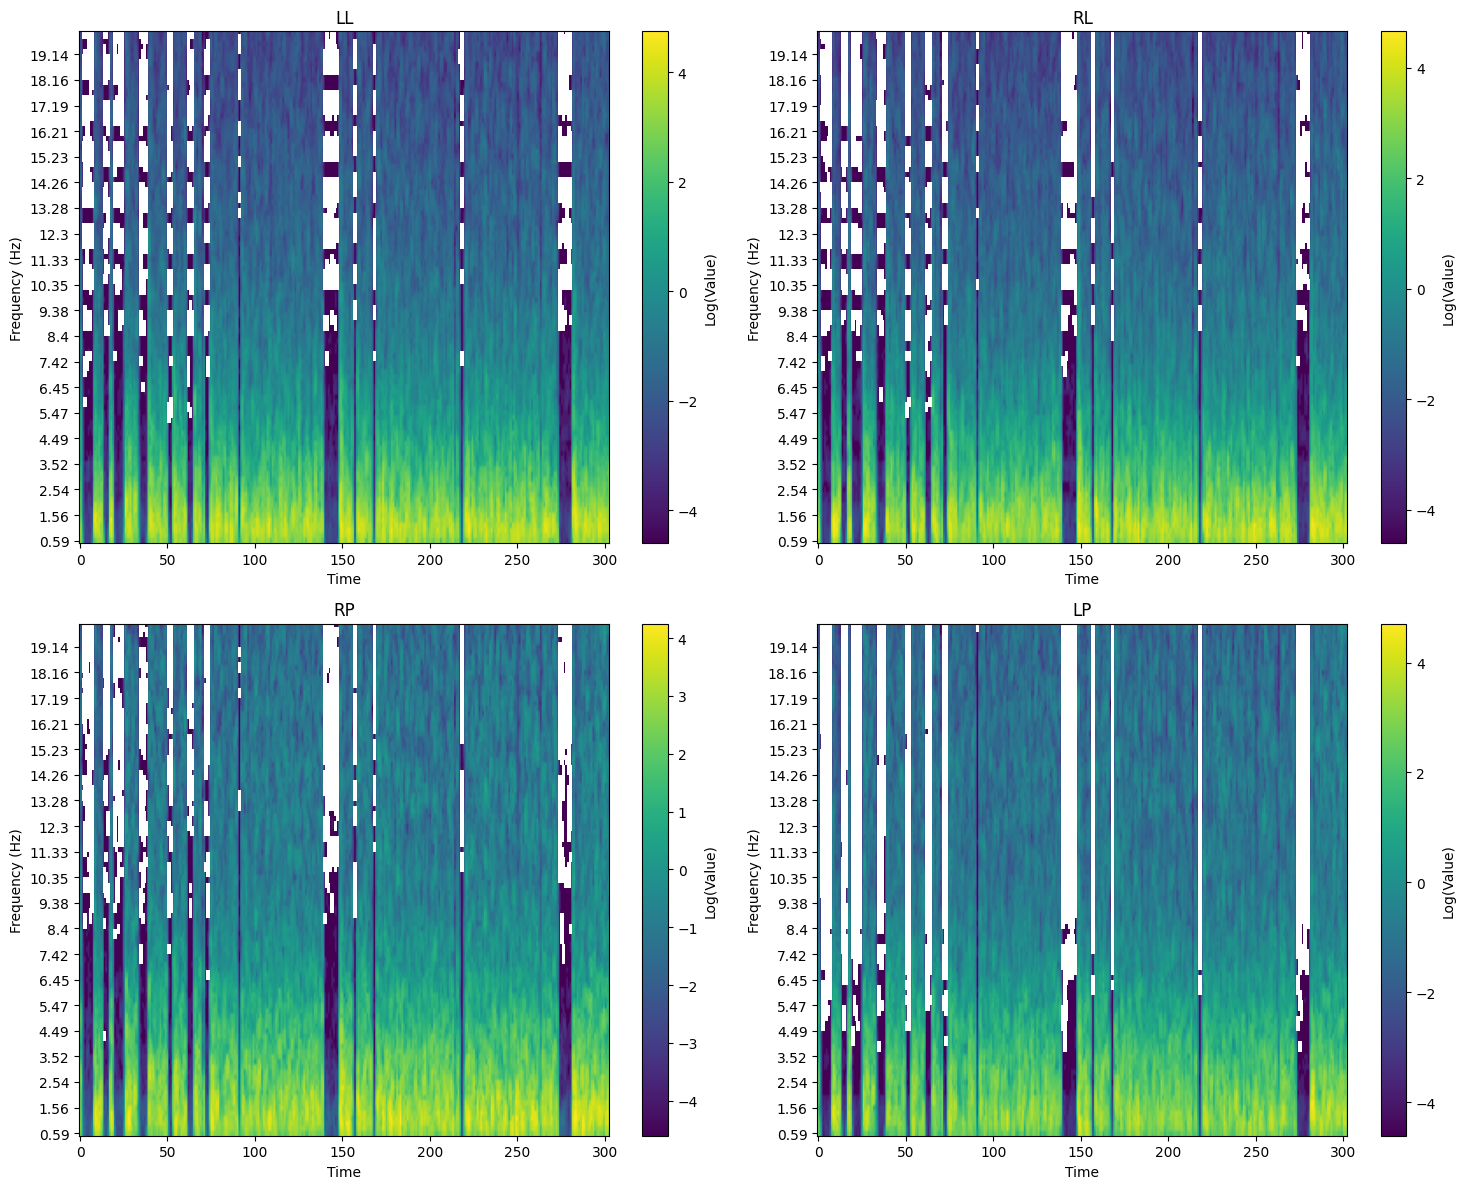

CPU times: user 1.14 s, sys: 3.1 s, total: 4.24 s
Wall time: 4 s


In [53]:
%%time
READ_SPEC_FILES = False

paths_spectograms = glob(paths.TRAIN_SPECTOGRAMS + "*.parquet")
print(f'There are {len(paths_spectograms)} spectrogram parquets')

if READ_SPEC_FILES:    
    all_spectrograms = {}
    for file_path in tqdm(paths_spectograms):
        aux = pd.read_parquet(file_path)
        name = int(file_path.split("/")[-1].split('.')[0])
        all_spectrograms[name] = aux.iloc[:, 1:].values
        del aux
else:
    all_spectrograms = np.load(paths.PRE_LOADED_SPECTOGRAMS, allow_pickle=True).item()
    
if CFG.VISUALIZE:
    idx = np.random.randint(0, len(paths_spectograms))
    spectrogram_path = paths_spectograms[idx]
    plot_spectrogram(spectrogram_path)

### <b><span style='color:#F1A424'>Read EEG Spectrograms</span></b>

The resulting `all_eegs` dictionary contains `eeg_id` as keys (`int` keys) and the values are the eeg sequences (as 3-dimensional `np.array`) of shape `(128, 256, 4)`.



In [54]:
%%time
READ_EEG_SPEC_FILES = False

paths_eegs = glob(paths.TRAIN_EEGS + "*.npy")
print(f'There are {len(paths_eegs)} EEG spectograms')

if READ_EEG_SPEC_FILES:
    all_eegs = {}
    for file_path in tqdm(paths_eegs):
        eeg_id = file_path.split("/")[-1].split(".")[0]
        eeg_spectogram = np.load(file_path)
        all_eegs[eeg_id] = eeg_spectogram
else:
    all_eegs = np.load(paths.PRE_LOADED_EEGS, allow_pickle=True).item()

There are 17089 EEG spectograms
CPU times: user 85.3 ms, sys: 3.57 s, total: 3.65 s
Wall time: 3.65 s


# <b><span style='color:#F1A424'>|</span> Validation</b><a class='anchor' id='validation'></a> [↑](#top) 

***

We train using `GroupKFold` on `patient_id`.

In [55]:
from sklearn.model_selection import KFold, GroupKFold

gkf = GroupKFold(n_splits=CFG.FOLDS)
for fold, (train_index, valid_index) in enumerate(gkf.split(train_df, train_df.target, train_df.patient_id)):
    train_df.loc[valid_index, "fold"] = int(fold)
    
display(train_df.groupby('fold').size()), sep()
display(train_df.head())

fold
0.0    3418
1.0    3418
2.0    3418
3.0    3418
4.0    3417
dtype: int64

----------------------------------------------------------------------------------------------------


,eeg_id,spectogram_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target,fold
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other,4.0
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD,2.0
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other,4.0
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD,2.0
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other,2.0


# <b><span style='color:#F1A424'>|</span> Dataset</b><a class='anchor' id='dataset'></a> [↑](#top) 

***

Create a custom `Dataset` to load data.

Our dataloader outputs both Kaggle spectrograms and EEG spectrogams as 8 channel image of size `(128, 256, 8)`

[1]: https://www.kaggle.com/code/cdeotte/efficientnetb0-starter-lb-0-43/comments#2617811

In [56]:
class CustomDataset(Dataset):
    def __init__(
        self, df: pd.DataFrame, config,
        augment: bool = False, mode: str = 'train',
        specs: Dict[int, np.ndarray] = all_spectrograms,
        eeg_specs: Dict[int, np.ndarray] = all_eegs
    ): 
        self.df = df
        self.config = config
        self.batch_size = self.config.BATCH_SIZE_TRAIN
        self.augment = augment
        self.mode = mode
        self.spectograms = all_spectrograms
        self.eeg_spectograms = eeg_specs
        
    def __len__(self):
        """
        Denotes the number of batches per epoch.
        """
        return len(self.df)
        
    def __getitem__(self, index):
        """
        Generate one batch of data.
        """
        X, y = self.__data_generation(index)
        if self.augment:
            X = self.__transform(X) 
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
                        
    def __data_generation(self, index):
        """
        Generates data containing batch_size samples.
        """
        X = np.zeros((128, 256, 8), dtype='float32')
        y = np.zeros(6, dtype='float32')
        img = np.ones((128,256), dtype='float32')
        row = self.df.iloc[index]
        if self.mode=='test': 
            r = 0
        else: 
            r = int((row['min'] + row['max']) // 4)
            
        for region in range(4):
            img = self.spectograms[row.spectogram_id][r:r+300, region*100:(region+1)*100].T
            
            # Log transform spectogram
            img = np.clip(img, np.exp(-4), np.exp(8))
            img = np.log(img)

            # standardize per image
            ep = 1e-6
            mu = np.nanmean(img.flatten())
            std = np.nanstd(img.flatten())
            img = (img-mu)/(std+ep)
            img = np.nan_to_num(img, nan=0.0)
            X[14:-14, :, region] = img[:, 22:-22] / 2.0
            img = self.eeg_spectograms[row.eeg_id]
            X[:, :, 4:] = img
                
            if self.mode != 'test':
                y = row[label_cols].values.astype(np.float32)
        return X, y
    
    def __transform(self, img):
        transforms = A.Compose([
            A.HorizontalFlip(p=0.5),
        ])
        return transforms(image=img)['image']

# <b><span style='color:#F1A424'>|</span> DataLoader</b><a class='anchor' id='dataloader'></a> [↑](#top) 

***

Below we display example dataloader spectrogram images.

In [57]:
train_dataset = CustomDataset(train_df, CFG, mode="train")

train_loader = DataLoader(
    train_dataset,
    batch_size=CFG.BATCH_SIZE_TRAIN,
    shuffle=False,
    num_workers=CFG.NUM_WORKERS, 
    pin_memory=True, 
    drop_last=True
)

X, y = train_dataset[0]
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: torch.Size([128, 256, 8])
y shape: torch.Size([6])


### <b><span style='color:#F1A424'> Visualize DataLoader</span></b>


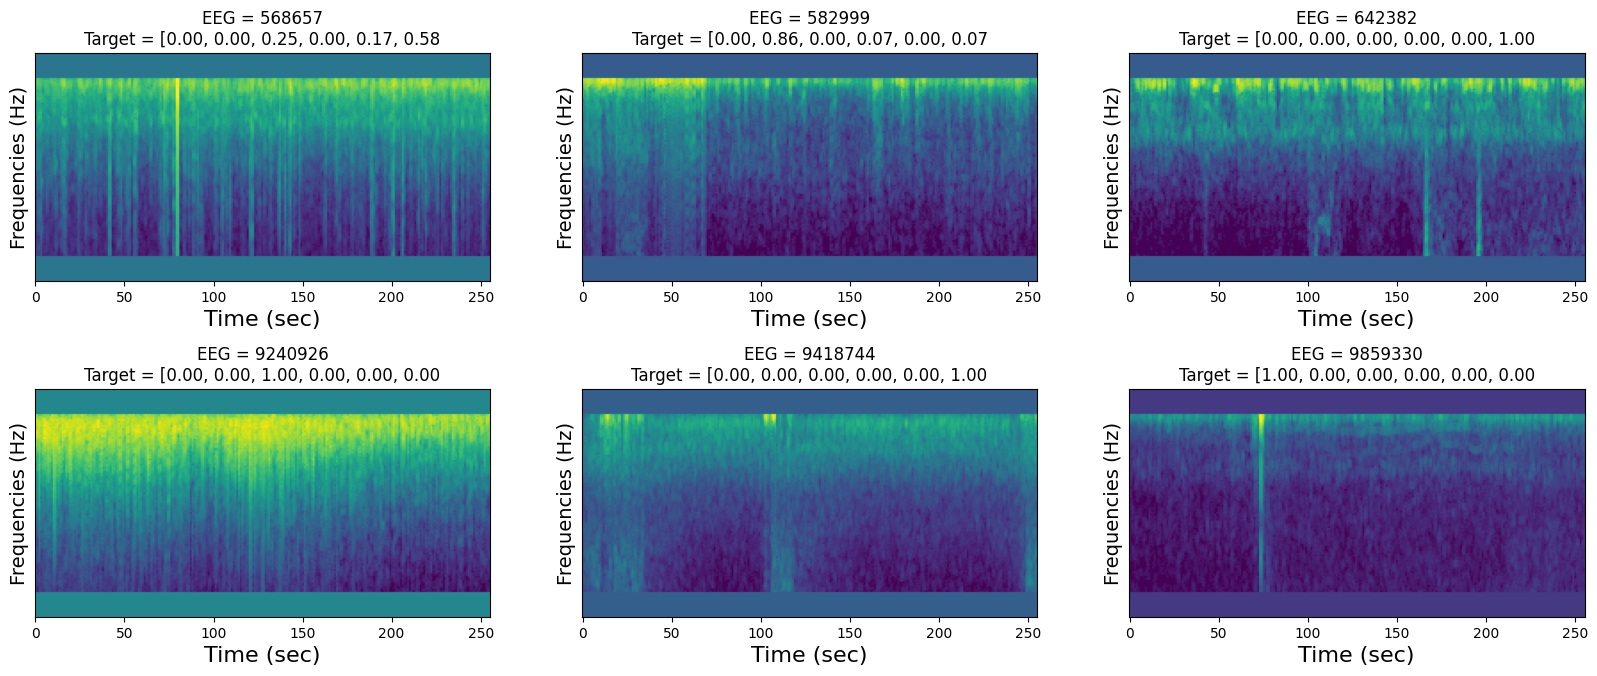

In [58]:
if CFG.VISUALIZE:
    ROWS = 2
    COLS = 3
    for (X, y) in train_loader:
        plt.figure(figsize=(20,8))
        for row in range(ROWS):
            for col in range(COLS):
                plt.subplot(ROWS, COLS, row*COLS + col+1)
                t = y[row*COLS + col]
                img = X[row*COLS + col, :, :, 0]
                mn = img.flatten().min()
                mx = img.flatten().max()
                img = (img-mn)/(mx-mn)
                plt.imshow(img)
                tars = f'[{t[0]:0.2f}'
                for s in t[1:]:
                    tars += f', {s:0.2f}'
                eeg = train_df.eeg_id.values[row * CFG.BATCH_SIZE_TRAIN + row * COLS + col]
                plt.title(f'EEG = {eeg}\nTarget = {tars}',size=12)
                plt.yticks([])
                plt.ylabel('Frequencies (Hz)',size=14)
                plt.xlabel('Time (sec)',size=16)
        plt.show()
        break

# <b><span style='color:#F1A424'>|</span> Model</b><a class='anchor' id='model'></a> [↑](#top) 

***

We will be using the [timm](https://github.com/huggingface/pytorch-image-models) library for our models.

Our models receives both Kaggle spectrograms and EEG spectrograms from our data loader. We then reshape these 8 spectrograms into 1 large flat image and feed it into EfficientNet.

In [59]:
class CustomModel(nn.Module):
    def __init__(self, config, num_classes: int = 6, pretrained: bool = True):
        super(CustomModel, self).__init__()
        self.USE_KAGGLE_SPECTROGRAMS = True
        self.USE_EEG_SPECTROGRAMS = True
        self.model = timm.create_model(
            config.MODEL,
            pretrained=pretrained,
            drop_rate = 0.1,
            drop_path_rate = 0.2,
        )
        if config.FREEZE:
            for i,(name, param) in enumerate(list(self.model.named_parameters())\
                                             [0:config.NUM_FROZEN_LAYERS]):
                param.requires_grad = False

        self.features = nn.Sequential(*list(self.model.children())[:-2])
        self.custom_layers = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(self.model.num_features, num_classes)
        )

    def __reshape_input(self, x):
        """
        Reshapes input (128, 256, 8) -> (512, 512, 3) monotone image.
        """ 
        # Get spectograms
        spectograms = [x[:, :, :, i:i+1] for i in range(4)]
        spectograms = torch.cat(spectograms, dim=1)
        
        # Get EEG spectograms
        eegs = [x[:, :, :, i:i+1] for i in range(4,8)]
        eegs = torch.cat(eegs, dim=1)
        
        # Reshape (512, 512, 3)
        if self.USE_KAGGLE_SPECTROGRAMS & self.USE_EEG_SPECTROGRAMS:
            x = torch.cat([spectograms, eegs], dim=2)
        elif self.USE_EEG_SPECTROGRAMS:
            x = eegs
        else:
            x = spectograms
            
        x = torch.cat([x, x, x], dim=3)
        x = x.permute(0, 3, 1, 2)
        return x
    
    def forward(self, x):
        x = self.__reshape_input(x)
        x = self.features(x)
        x = self.custom_layers(x)
        return x

# <b><span style='color:#F1A424'>|</span> Scheduler</b><a class='anchor' id='scheduler'></a> [↑](#top) 

***

- We will train our model with a Step Train Schedule for 4 epochs. 
- First 2 epochs are LR=1e-3. 
- Then epochs 3 and 4 use LR=1e-4 and 1e-5 respectively. 
- Below is a Cosine Train Schedule to experiment with. Note it is not used in this notebook

Maximum LR: 0.0009999999760405812 | Minimum LR: 4.0000000000000003e-07


/home/noone/Documents/GitHub/kaggle_hms_harmful_brain_activity/venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


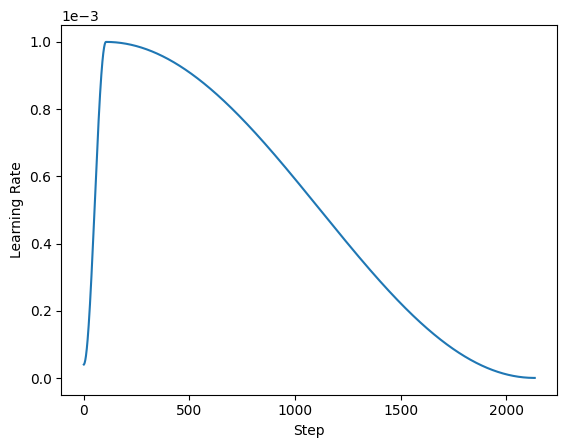

In [60]:
from torch.optim.lr_scheduler import OneCycleLR

EPOCHS = CFG.EPOCHS
BATCHES = len(train_loader)
steps = []
lrs = []
optim_lrs = []
model = CustomModel(CFG)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

scheduler = OneCycleLR(
    optimizer,
    max_lr=1e-3,
    epochs=CFG.EPOCHS,
    steps_per_epoch=len(train_loader),
    pct_start=0.05,
    anneal_strategy="cos",
    final_div_factor=100,
)
for epoch in range(EPOCHS):
    for batch in range(BATCHES):
        scheduler.step()
        lrs.append(scheduler.get_last_lr()[0])
        steps.append(epoch * BATCHES + batch)

max_lr = max(lrs)
min_lr = min(lrs)
print(f"Maximum LR: {max_lr} | Minimum LR: {min_lr}")

plt.figure()
plt.plot(steps, lrs, label='OneCycle')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.show()

# <b><span style='color:#F1A424'>|</span> Loss Function</b><a class='anchor' id='loss'></a> [↑](#top) 

***

In PyTorch's [KLDivLoss][1], the reduction parameter determines how the loss is aggregated across different dimensions. Two common options are `mean` and `batchmean`.

- `reduction`='mean': When reduction is set to "mean", the Kullback-Leibler Divergence loss is computed and then averaged over all the elements in the input tensor. The result is a scalar value representing the mean loss.
- `reduction`='batchmean': When reduction is set to "batchmean", the Kullback-Leibler Divergence loss is computed independently for each item in the batch, and then the mean is taken over the batch dimension. This is useful when you have a batch of samples, and you want the average loss per sample.

[1]: https://pytorch.org/docs/stable/generated/torch.nn.KLDivLoss.html


In [61]:
import torch.nn.functional as F

# Reduction = "mean"
criterion = nn.KLDivLoss(reduction="mean")
y_pred = F.log_softmax(torch.randn(6, 2, requires_grad=True), dim=1)
y_true = F.softmax(torch.rand(6, 2), dim=1)
print(f"Predictions: {y_pred}")
print(f"Targets: {y_true}")
output = criterion(y_pred, y_true)
print(f"Output: {output}")

print("\n", "="*100, "\n")

# reduction = "batchmean"
criterion = nn.KLDivLoss(reduction="batchmean")
y_pred = F.log_softmax(torch.randn(2, 6, requires_grad=True), dim=1)
y_true = F.softmax(torch.rand(2, 6), dim=1)
print(f"Predictions: {y_pred}")
print(f"Targets: {y_true}")
output = criterion(y_pred, y_true)
print(f"Output: {output}")

Predictions: tensor([[-0.3379, -1.2493],
        [-1.7301, -0.1951],
        [-1.0611, -0.4248],
        [-0.5970, -0.7996],
        [-1.4067, -0.2810],
        [-0.9767, -0.4725]], grad_fn=<LogSoftmaxBackward0>)
Targets: tensor([[0.4612, 0.5388],
        [0.4630, 0.5370],
        [0.4915, 0.5085],
        [0.5109, 0.4891],
        [0.5114, 0.4886],
        [0.5910, 0.4090]])
Output: 0.05497143790125847


Predictions: tensor([[-2.1752, -2.3217, -2.7064, -1.0754, -3.2781, -1.0710],
        [-1.3592, -2.2117, -1.3815, -1.5279, -2.3172, -2.7050]],
       grad_fn=<LogSoftmaxBackward0>)
Targets: tensor([[0.1145, 0.1359, 0.1251, 0.2119, 0.1727, 0.2400],
        [0.0929, 0.0945, 0.1935, 0.1980, 0.2176, 0.2035]])
Output: 0.2109779417514801


/home/noone/Documents/GitHub/kaggle_hms_harmful_brain_activity/venv/lib/python3.10/site-packages/torch/nn/functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


# <b><span style='color:#F1A424'>|</span> Train and Validation Functions</b><a class='anchor' id='functions'></a> [↑](#top) 

***

- We train using Group KFold on patient id. 
- If `LOAD_MODELS_FROM = None`, then we will train new models in this notebook version. 
- Otherwise we will load saved models from the path `LOAD_MODELS_FROM`.

In [62]:
# Initialize wandb
wandb.init(
    project="harmful_brain_activity", 
    entity="michael_kingston",
    config={
        "initial_learning_rate": 1e-3,
        "batch_size": CFG.BATCH_SIZE_TRAIN,
        "epochs": CFG.EPOCHS,
    },
    tags=["EfficientNet", "Kaggle", "Pytorch"],
)

epoch,▁▁▃▃▆▆██▁▁▃▃▆▆██▁▁▃▃▆▆██▁▁▃▃▆▆██▁▁▃▃▆▆██
grad_norm,█▃▂▃▃▅▁▂▆▄▃▄▃▃▂▂▇▃▄▅▃▃▂▃▆▃▁▄▂▁▂▃█▇▃▂▅▃▄▂
learning_rate,▃██▆▅▃▂▁▃█▇▆▄▃▂▁▃█▇▆▄▃▂▁██▇▆▄▃▂▁██▇▅▄▂▁▁
loss,█▅▄▃▂▂▁▁█▅▃▃▂▂▁▁█▅▃▃▂▂▁▁▆▅▃▃▂▂▁▁▆▅▃▃▂▂▁▁
step,▂▅▁▆▂▅▁▆▂▅▁▆▂█▁▆▂█▁▆▂█▁▆▂█▄▆▂█▄▆▂█▄▆▂█▄█
validation_loss,██▆▇▆▆▅▆▇█▇▆▅▆▇▅▆▆▃▅▄▄▁▄▇█▆▆▅▆▆▅▆▇▄▅▄▅▄▄
epoch,4
grad_norm,58783.73047
learning_rate,0.0
loss,0.32804
step,106


# <b><span style='color:#F1A424'>|</span> Train Epoch</b><a class='anchor' id='train_epoch'></a>

***

In [63]:
def train_epoch(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    """One epoch training pass."""
    model.train() 
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.AMP)
    losses = AverageMeter()
    global_step = 0  # Initialize global_step here
    start = time.time()
    
    # iterate over train batches
    with tqdm(train_loader, unit="train_batch", desc='Train') as tqdm_train_loader:
        for step, (X, y) in enumerate(tqdm_train_loader):
            X = X.to(device)
            y = y.to(device)
            batch_size = y.size(0)
            
            with torch.cuda.amp.autocast(enabled=CFG.AMP):
                y_preds = model(X) 
                loss = criterion(F.log_softmax(y_preds, dim=1), y)
                
            if CFG.GRADIENT_ACCUMULATION_STEPS > 1:
                loss = loss / CFG.GRADIENT_ACCUMULATION_STEPS
            losses.update(loss.item(), batch_size)
            
            # backward pass
            scaler.scale(loss).backward()
            
            # gradient clipping and optimiser step
            grad_norm = None
            if (step + 1) % CFG.GRADIENT_ACCUMULATION_STEPS == 0:
                grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.MAX_GRAD_NORM)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                global_step += 1
                scheduler.step()

            # logging info
            if step % CFG.PRINT_FREQ == 0 or step == (len(train_loader) - 1):
                log_message = f"""
                Epoch: [{epoch+1}][{step}/{len(train_loader)}] \n
                Elapsed {time_since(start, float(step + 1) / len(train_loader))} \n
                Loss: {losses.avg:.4f} \n
                Grad: {'N/A' if grad_norm is None else f'{grad_norm:.4f}'} \n
                LR:{scheduler.get_last_lr()[0]:.8f}"""
            
                logging.info(log_message)
            
                wandb.log({
                    "loss": losses.avg, 
                    "grad_norm": 0 if grad_norm is None else grad_norm, 
                    "learning_rate": scheduler.get_last_lr()[0], 
                    "epoch": epoch + 1
                })

    return losses.avg

# <b><span style='color:#F1A424'>|</span> Validation Epoch</b><a class='anchor' id='valid_epoch'></a> 

***

In [64]:
def valid_epoch(valid_loader, model, criterion, device):
    """
    
    :param valid_loader: 
    :param model: 
    :param criterion: 
    :param device: 
    :return: 
    """
    model.eval()
    losses = AverageMeter()
    preds = []  # for probabilities
    logits_list = []  # for raw logits
    prediction_dict = {}  # Initialize prediction_dict here
    start = time.time()
    
    with tqdm(valid_loader, unit="valid_batch", desc='Validation') as tqdm_valid_loader:
        for step, (X, y) in enumerate(tqdm_valid_loader):
            X = X.to(device)
            y = y.to(device)
            batch_size = y.size(0)
            
            with torch.no_grad():
                logits = model(X)
                loss = criterion(F.log_softmax(logits, dim=1), y)
                probabilities = F.softmax(logits, dim=1)  # compute softmax probabilities from logits
            
            # update loss
            if CFG.GRADIENT_ACCUMULATION_STEPS > 1:
                loss = loss / CFG.GRADIENT_ACCUMULATION_STEPS
            losses.update(loss.item(), batch_size)
            
            # store predictions and logits
            preds.append(probabilities.cpu().numpy())
            logits_list.append(logits.cpu().numpy())

            # log info
            if step % CFG.PRINT_FREQ == 0 or step == (len(valid_loader) - 1):
                # aggregate and log metrics
                log_message = """
                EVAL: [{0}/{1}] \n
                Elapsed {remain:s} \n
                Loss: {loss.avg:.4f} \n
                """.format(
                    step, 
                    len(valid_loader),
                    remain=time_since(start, float(step + 1) / len(valid_loader)), 
                    loss=losses
                )
                
                logging.info(log_message)
                
                wandb.log({
                    "validation_loss": losses.avg,
                    "step": step,
                })
                
    aggregated_logits = np.concatenate(logits_list)
    aggregated_probs = np.concatenate(preds)
    
    wandb.log({
        "aggregated_logits": aggregated_logits,
        "aggregated_probs": aggregated_probs
    })
    
    prediction_dict["predictions"] = aggregated_probs
    return losses.avg, prediction_dict

# <b><span style='color:#F1A424'>|</span> Train Loop</b><a class='anchor' id='train_loop'></a> [↑](#top) 

***

In [65]:
def train_loop(df, fold):
    """Train and validate one fold."""
    LOGGER.info(f"========== Fold: {fold} training ==========")

    # split
    train_folds = df[df['fold'] != fold].reset_index(drop=True)
    valid_folds = df[df['fold'] == fold].reset_index(drop=True)
    
    # datasets
    train_dataset = CustomDataset(
        train_folds, 
        CFG, 
        mode="train", 
        augment=True
    )
    
    valid_dataset = CustomDataset(
        valid_folds, 
        CFG, 
        mode="train", 
        augment=False
    )
    
    # dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=CFG.BATCH_SIZE_TRAIN,
        shuffle=True,
        num_workers=CFG.NUM_WORKERS, 
        pin_memory=True, drop_last=True
    )
    
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=CFG.BATCH_SIZE_VALID,
        shuffle=True,
        num_workers=CFG.NUM_WORKERS, 
        pin_memory=True, 
        drop_last=False
    )
    
    # model
    model = CustomModel(CFG)
    model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=0.1, weight_decay=CFG.WEIGHT_DECAY)
    
    scheduler = OneCycleLR(
        optimizer,
        max_lr=1e-3,
        epochs=CFG.EPOCHS,
        steps_per_epoch=len(train_loader),
        pct_start=0.1,
        anneal_strategy="cos",
        final_div_factor=100,
    )

    # loss
    criterion = nn.KLDivLoss(reduction="batchmean")
    
    best_loss = np.inf
    # iterate epochs
    for epoch in range(CFG.EPOCHS):
        start_time = time.time()

        # training
        avg_train_loss = train_epoch(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # validation / evaluation
        avg_val_loss, prediction_dict = valid_epoch(valid_loader, model, criterion, device)
        predictions = prediction_dict["predictions"]
        
        # scoring
        elapsed = time.time() - start_time
        LOGGER.info(f'Epoch {epoch + 1} - avg_train_loss: {avg_train_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        
        # WandB Logging
        wandb.log({
            "epoch": epoch + 1,
            "avg_train_loss": avg_train_loss,
            "avg_val_loss": avg_val_loss,
            "epoch_time": elapsed
        })
        
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
            torch.save(
                {'model': model.state_dict(), 
                 'predictions': predictions},
                paths.OUTPUT_DIR + f"/{CFG.MODEL.replace('/', '_')}_fold_{fold}_best.pth"
            )

    predictions = torch.load(
        paths.OUTPUT_DIR + f"/{CFG.MODEL.replace('/', '_')}_fold_{fold}_best.pth",
		map_location=torch.device('cpu')
    )['predictions']
    
    valid_folds[target_preds] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

# <b><span style='color:#F1A424'>|</span> Train Full Data</b><a class='anchor' id='train_full'></a> [↑](#top) 

***

In [66]:
def train_loop_full_data(df):
    train_dataset = CustomDataset(
        df, 
        CFG, 
        mode="train", 
        augment=True
    )
    
    train_loader = DataLoader(
        train_dataset,
		batch_size=CFG.BATCH_SIZE_TRAIN,
		shuffle=True,
		num_workers=CFG.NUM_WORKERS, 
        pin_memory=True, 
        drop_last=True
    )
    
    model = CustomModel(CFG)
    model.to(device)
    
    optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=0.1, 
        weight_decay=CFG.WEIGHT_DECAY
    )
    
    scheduler = OneCycleLR(
        optimizer,
        max_lr=1e-3,
        epochs=CFG.EPOCHS,
        steps_per_epoch=len(train_loader),
        pct_start=0.1,
        anneal_strategy="cos",
        final_div_factor=100,
    )
    criterion = nn.KLDivLoss(reduction="batchmean")

    for epoch in range(CFG.EPOCHS):
        start_time = time.time()
        avg_train_loss = train_epoch(train_loader, model, criterion, optimizer, epoch, scheduler, device)
        elapsed = time.time() - start_time
        
        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_train_loss:.4f}  time: {elapsed:.0f}s')
        
        # WandB Logging
        wandb.log({
            "epoch": epoch + 1,
            "avg_train_loss": avg_train_loss,
            "epoch_time": elapsed
        })
        
        torch.save(
            {'model': model.state_dict()},
            paths.OUTPUT_DIR + f"/{CFG.MODEL.replace('/', '_')}_epoch_{epoch}.pth")
    
    torch.cuda.empty_cache()
    gc.collect()
    return model

get result function

In [ ]:
def get_result(oof_df):
    """

    :param oof_df: 
    :return: 
    """
    kl_loss = nn.KLDivLoss(reduction="batchmean")
    labels = torch.tensor(oof_df[label_cols].values)
    preds = torch.tensor(oof_df[target_preds].values)
    preds = F.log_softmax(preds, dim=1)
    result = kl_loss(preds, labels)
    return result

# <b><span style='color:#F1A424'>|</span> Train</b><a class='anchor' id='train'></a> [↑](#top) 

***

In [ ]:
# Train on full data
train_loop_full_data(train_df)

Train: 100%|██████████| 534/534 [01:58<00:00,  4.52train_batch/s]
Epoch 1 - avg_train_loss: 0.7557  time: 118s
Epoch 1 - avg_train_loss: 0.7557  time: 118s
Epoch 1 - avg_train_loss: 0.7557  time: 118s
Train:  43%|████▎     | 228/534 [00:49<01:08,  4.47train_batch/s]

cross validation

In [ ]:
# Perform k-fold cross-validation
oof_df = pd.DataFrame()
for fold in range(CFG.FOLDS):
    _oof_df = train_loop(train_df, fold)
    oof_df = pd.concat([oof_df, _oof_df])
    fold_result = get_result(_oof_df)
    LOGGER.info(f"========== Fold {fold} result: {fold_result} ========== \n")
    print(f"========== Fold {fold} result: {fold_result} ========== \n")
    wandb.log({"fold_result": fold_result, "fold": fold})

oof_df = oof_df.reset_index(drop=True)
cv_result = get_result(oof_df)
LOGGER.info(f"========== CV: {cv_result} ==========")
wandb.log({"cv_result": cv_result})
oof_df.to_csv(paths.OUTPUT_DIR + '/oof_df.csv', index=False)

Final Training on Full Dataset:
- After completing cross-validation and choosing the best hyperparameters, train the model on the entire dataset.
- This final model is what you would typically use for deployment or real-world predictions.

In [ ]:
final_model = train_loop_full_data(train_df)
final_model_path = paths.OUTPUT_DIR + f"/{CFG.MODEL.replace('/', '_')}_final.pth"
torch.save({'model': final_model.state_dict()}, final_model_path)

Main loop

In [ ]:
# if not CFG.TRAIN_FULL_DATA:
#     oof_df = pd.DataFrame()
#     for fold in range(CFG.FOLDS):
#         if fold in [0, 1, 2, 3, 4]:
#             _oof_df = train_loop(train_df, fold)
#             oof_df = pd.concat([oof_df, _oof_df])
#             LOGGER.info(f"========== Fold {fold} result: {get_result(_oof_df)} ========== \n")
#             print(f"========== Fold {fold} result: {get_result(_oof_df)} ========== \n")
#     oof_df = oof_df.reset_index(drop=True)
#     LOGGER.info(f"========== CV: {get_result(oof_df)} ==========")
#     oof_df.to_csv(paths.OUTPUT_DIR + '/oof_df.csv', index=False)
# else:
#     train_loop_full_data(train_df)